In [1]:
import os
import sys

In [2]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
import copy
import math

import numpy as np
import scipy
import scipy.stats
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from matplotlib.contour import QuadContourSet
from matplotlib.legend_handler import HandlerBase
from matplotlib import ticker
from itertools import cycle
from collections import defaultdict

# configure matplotlib
%matplotlib inline
# %matplotlib notebook

In [4]:
#mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('font',**{'family':'serif'})
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

In [5]:
from cdi.util.analysis.plotting import plot_colorline

## Helpers

In [6]:
def compute_joint(X):
    mean = X.mean(axis=0)
    cov = np.cov(X, rowvar=False, ddof=1)
    
    return mean, cov

In [7]:
def initial_imputation(X, M):
    X = X.copy()
    
    # Use empirical marginal sample imputation
    M_not = ~M
    count_missing_per_dim = (M_not).sum(axis=0)
    # Impute each dimension
    for i in range(M.shape[-1]):
        samples = np.random.choice(X[:, i][M[:, i]],
                                   size=count_missing_per_dim[i])
        X[M_not[:, i], i] = samples

    return X

In [8]:
def compute_univariate_conditionals(X, M, mean, cov):
    X, M = torch.tensor(X), torch.tensor(M)
    
    mean = torch.tensor(mean)
    cov = torch.tensor(cov)
    
    dims = torch.arange(X.shape[-1])
    means = torch.empty_like(X)
    vs = torch.empty_like(X)
    for dim in range(X.shape[-1]):
        M = ~(dims == dim)
        M_not = ~M
        cov_mm = cov[M_not.unsqueeze(-1) * M_not.unsqueeze(-2)]
        cov_mo = cov[M_not.unsqueeze(-1) * M.unsqueeze(-2)]
        cov_oo = cov[M.unsqueeze(-1) * M.unsqueeze(-2)]
        
        # Compute the posterior var
#         Z = torch.inverse(cov_oo) @ cov_mo.T
        # Pytorch fails to compute inverse of scalar matrices (1 element)
        Z = (1/cov_oo) @ cov_mo.T
        Z = Z.unsqueeze(-1)
        var = cov_mm - cov_mo @ Z
        
        # Compute the posterior mean
        m = mean[M_not] + Z @ (X[:, M] - mean[M]).unsqueeze(-1)
        
        means[:, dim] = m.squeeze()
        vs[:, dim] = var
        
    return means.numpy(), (vs**(1/2)).numpy()

In [9]:
def impute_with_conditional_samples(X, M, means, stds, repeat=1):
    X = X.copy()
    M_not = ~M
    M_not = M_not.copy()
    
    fully_missing = M_not.sum(axis=1) == X.shape[-1]
    
    for _ in range(repeat):
        M_not_temp = M_not.copy()
        mis_dim = np.random.randint(0, X.shape[-1], dtype=np.int, size=(fully_missing.sum(),1)).flatten()
        M_not_temp[fully_missing, :] = 0
        M_not_temp[fully_missing, mis_dim] = 1

        dims = np.arange(X.shape[-1])
        for dim in range(X.shape[-1]):
            mis = M_not_temp[:, dim]

            X_mis = X[mis, :]
            means_mis = means[mis, dim]
            stds_mis = stds[mis, dim]
            for i in range(X_mis.shape[0]):
                X_mis[i, dim] = means_mis[i] + np.random.randn()*stds_mis[i]

            X[mis, dim] = X_mis[:, dim]
    
    return X

## Figure defaults

In [10]:
figsize = (5, 5.3)
ylim = (-5, 5)
xlim = (-5, 5)
tick_params = {'labelbottom': False, 'labelleft': False, 'bottom': False, 'left': False}

grid = np.mgrid[-6:6:.01, -6:6:.01]
line = np.arange(-6, 6, 0.01)
contour_levels= 10


contour_linewidth = 3
line_linewidth = 2

scatter_linewidth = 1
scatter_marker_size = 35
scatter_marker_size_big = 150
# scatter_mis_marker_shape = 'x'
scatter_mis0_marker_shape = 's'
scatter_mis1_marker_shape = 'D'
scatter_misb_marker_shape = 'X'
scatter_mis0_marker_color = 'b'
scatter_mis1_marker_color = 'g'
scatter_misb_marker_color = 'r'

scatter_obs_marker_size = 35
scatter_obs_marker_shape = 'o'
scatter_obs_marker_color = 'k'

prev_scatter_alpha = 0.5

legend_fontsize = 14

xy_label_size = 18
minor_tick_length = 5

big_label_size = 40
med_label_size = 22
big_label_pad = 20

### Figure helpers

In [11]:
def hide_major_ticks(ax):
    # Hide x major ticks
    for tic in ax.xaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)
        tic.label1.set_visible(False)
        tic.label2.set_visible(False)

    # Hide y major ticks
    for tic in ax.yaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)
        tic.label1.set_visible(False)
        tic.label2.set_visible(False)

In [12]:
def set_ticks_and_labels(ax, X, M):
    xticks = X[M[:, 0] | (M.sum(axis=1)==0), 0]
    yticks = X[M[:, 1] | (M.sum(axis=1)==0), 1]
    
    xlabels = [f'{x:.1f}' for x in xticks]
    ylabels = [f'{y:.1f}' for y in yticks]
    
    # Set xtick locations to the values of the array `x_ticks`
    ax.set_xticks(xticks, minor=True)
    ax.set_xticklabels(xlabels, minor=True)
    ax.set_yticks(yticks, minor=True)
    ax.set_yticklabels(ylabels, minor=True)

In [13]:
def plot_scatter(ax, X, M, 
                 o_color=scatter_obs_marker_color,
                 m0_color=scatter_mis0_marker_color, 
                 m1_color=scatter_mis1_marker_color, 
                 mb_color=scatter_misb_marker_color, 
                 o_shape=scatter_obs_marker_shape,
                 m0_shape=scatter_mis0_marker_shape, 
                 m1_shape=scatter_mis1_marker_shape, 
                 mb_shape=scatter_misb_marker_shape, 
                 o_size=scatter_obs_marker_size,
                 m_size=scatter_marker_size,
                 linewidth=scatter_linewidth,
                 zorder=None,
                 alpha=1.0):
    fully_observed = M.sum(axis=1) == X.shape[-1]
    fully_miss = M.sum(axis=1) == 0
    missing_0 = ~M[:, 0] & M[:, 1]
    missing_1 = ~M[:, 1] & M[:, 0]
    
    ax.scatter(X[fully_observed, 0], X[fully_observed, 1], 
               marker=o_shape, 
               color=o_color, 
               s=o_size, 
               linewidth=linewidth,
               zorder=zorder,
               alpha=alpha)
    ax.scatter(X[fully_miss, 0], X[fully_miss, 1], 
               marker=mb_shape, 
               color=mb_color, 
               s=m_size, 
               linewidth=linewidth,
               zorder=zorder,
               alpha=alpha)
    ax.scatter(X[missing_0, 0], X[missing_0, 1], 
               marker=m0_shape, 
               color=m0_color, 
               s=m_size, 
               linewidth=linewidth,
               zorder=zorder,
               alpha=alpha)
    ax.scatter(X[missing_1, 0], X[missing_1, 1], 
               marker=m1_shape, 
               color=m1_color, 
               s=m_size, 
               linewidth=linewidth,
               zorder=zorder,
               alpha=alpha)


In [14]:
def plot_joint_density_contours(ax, mean, cov, zorder=None):
    x0, x1 = grid.copy()
    pos = np.empty(x0.shape + (2,))
    pos[:, :, 0] = x0; pos[:, :, 1] = x1

    density = scipy.stats.multivariate_normal(mean, cov=cov)
    pdf = density.pdf(pos)
    
#     norm = plt.Normalize(0.0, 0.1)
#     norm = mcolors.LogNorm()
#     norm = None
    norm = plt.Normalize(pdf.min(), pdf.max())
#     norm = plt.Normalize(0.0, 1.0)
#     pdf2 = (pdf - pdf.min()) / (pdf.max() - pdf.min())
    contour = ax.contourf(x0, x1, pdf, zorder=zorder,
                          norm=norm, linewidths=contour_linewidth, levels=contour_levels)
    
    # Plot some random line as colorlines to check if we can plot in the correct color scale.
#     ax.plot(line, np.tile(x0[400, 0], line.shape), color='r', linewidth=5, zorder= zorder+1)
#     plot_colorline(ax, 
#                    x=line, y=np.tile(x0[400, 0], line.shape), z=pdf2[:, 400], 
#                    norm=norm, 
#                    zorder=zorder+2,
#                    linewidth=line_linewidth)
    
#     ax.plot(np.tile(x1[0, 600], line.shape), line, color='r', linewidth=5, zorder= zorder+1)
#     plot_colorline(ax, 
#                    x=np.tile(x1[0, 600], line.shape), y=line,  z=pdf2[600, :], 
#                    norm=norm, 
#                    zorder=zorder+2,
#                    linewidth=line_linewidth)

    return pdf

In [15]:
def plot_univariate_conditionals(ax, X, M, means, stds, joint_mean, joint_cov, joint_pdf=None, zorder=None):
    # NOTE: for the gaussian case we could get the univariate pdfs from the joint_pdf
    # by just selecting the corresponding row
    
    if joint_pdf is not None:
        max_density = joint_pdf.max()
        min_density = joint_pdf.min()
    else:
        max_density = None
        min_density = None
    
    dims = torch.arange(X.shape[-1])
    for dim in range(X.shape[-1]):
        mis = ~M[:, dim]
        xo = X[mis, dims != dim]
        mo = joint_mean[dims != dim]
        so = joint_cov[dims != dim, dims != dim]**(1/2)
        mm = means[mis, dim]
        sm = stds[mis, dim]
        
        pdfs = np.empty((xo.shape[0], line.shape[0]))
        for i in range(xo.shape[0]):
            obs_prob = scipy.stats.norm.pdf(xo[i], loc=mo, scale=so)
            
            density = scipy.stats.norm(loc=mm[i], scale=sm[i])
            pdfs[i] = density.pdf(line)
            
            # Set color scaling to the scale of the joint graph
            if joint_pdf is not None:
#                 norm = plt.Normalize(0.0, 1.0)
                norm = plt.Normalize(min_density, max_density)
#                 norm = None
            else:
                norm = None
            
            # Scale the pdf of the i-th conditional using it's observed marginal probability
#             plot_pdf_i = (pdfs[i] * obs_prob - min_density) / (max_density - min_density)
            plot_pdf_i = pdfs[i] * obs_prob
            
            # Plot the pdf as line either horizontally or vertically
            if dim == 0:
                plot_colorline(ax, 
                               x=line, y=np.tile(xo[i], line.shape), z=plot_pdf_i, 
                               norm=norm, 
                               zorder=zorder,
                               linewidth=line_linewidth)
            else:
                plot_colorline(ax, 
                               x=np.tile(xo[i], line.shape), y=line, z=plot_pdf_i, 
                               norm=norm, 
                               zorder=zorder, 
                               linewidth=line_linewidth)


In [16]:
def plot_univariate_conditional_sideview(ax, dim, x, m, means, stds, 
                                         joint_mean, joint_cov, joint_pdf=None, 
                                         plot_point=False,
                                         m0_color=scatter_mis0_marker_color, 
                                         m1_color=scatter_mis1_marker_color, 
                                         mb_color=scatter_misb_marker_color, 
                                         m0_shape=scatter_mis0_marker_shape, 
                                         m1_shape=scatter_mis1_marker_shape, 
                                         mb_shape=scatter_misb_marker_shape, 
                                         zorder=None):
    dims = np.arange(x.shape[-1])
    obs_prob = scipy.stats.norm.pdf(x[dims != dim], 
                                    loc=joint_mean[dims != dim], 
                                    scale=joint_cov[dims != dim, dims != dim]**(1/2))
    
    pdf = scipy.stats.norm.pdf(line, loc=means[dim], scale=stds[dim])
    
    # Scale colors depending on observed part
    z_pdf = pdf * obs_prob
    
    norm = plt.Normalize(joint_pdf.min(), joint_pdf.max())
    if dim == 0:
        plot_colorline(ax, x=line, y=pdf, z=z_pdf, norm=norm, linewidth=line_linewidth, zorder=zorder)
    elif dim == 1:
        plot_colorline(ax, x=pdf, y=line, z=z_pdf, norm=norm, linewidth=line_linewidth, zorder=zorder)
        
    if plot_point and dim == 0:
        color = mb_color if m.sum() == 0 else m0_color
        shape = mb_shape if m.sum() == 0 else m0_shape
            
        ax.scatter(x[dim], 0, marker=scatter_mis_marker_shape, color=color, 
                   s=scatter_marker_size, linewidth=scatter_linewidth, zorder=zorder)
    elif plot_point and dim == 1:
        color = mb_color if m.sum() == 0 else m1_color
        shape = mb_shape if m.sum() == 0 else m1_shape
        
        ax.scatter(0, x[dim], marker=scatter_mis_marker_shape, color=color, 
                   s=scatter_marker_size, linewidth=scatter_linewidth, zorder=zorder)

    if dim == 0:
        ax.set_ylabel(f'$x_1 = {x[1]:.1f}$', fontsize=xy_label_size)
    elif dim == 1:
        ax.set_xlabel(f'$x_0 = {x[0]:.1f}$', fontsize=xy_label_size)
        ax.xaxis.set_label_position('top')

## Generate data

In [17]:
np.random.seed(2020092214)
mean = np.array([0,0])
cov = np.array([
    [1, 2],
    [2, 5]
])

N = 50
X = np.random.multivariate_normal(mean=mean, cov=cov, size=(N))

miss = 0.25
M = np.zeros(X.size, dtype=np.bool)
M[0:math.floor(M.size*(1-miss))] = 1
np.random.shuffle(M)
M = M.reshape(X.shape)

## Visualisation

In [18]:
# np.concatenate([X, np.arange(X.shape[0])[:, None]], axis=1)

In [19]:
# Choose some missing data points manually
# M = np.ones_like(X, dtype=np.bool)

# Option 1
# # 0-dim missing
# M[[2, 6, 18], :] = np.array([0, 1])
# # 1-dim missing
# M[[5, 11, 14], :] = np.array([1, 0])

# Option 2
# # 0-dim missing
# M[[2, 18], :] = np.array([0, 1])
# # 1-dim missing
# M[[5, 14], :] = np.array([1, 0])
# # Both dims missing
# M[[6,], :] = np.array([0, 0])

### True data

<ipython-input-14-dce7d73994b5>:15: UserWarning: linewidths is ignored by contourf
  contour = ax.contourf(x0, x1, pdf, zorder=zorder,


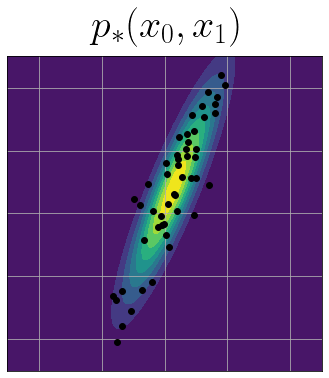

In [20]:
f = plt.figure(figsize=figsize)
ax = f.add_subplot(111)

param = compute_joint(X)
plot_joint_density_contours(ax, *param, zorder=0)
# plot_scatter(ax, X, M, zorder=10)
plot_scatter(ax, X, M, 
             m0_color='k', 
             m1_color='k', 
             mb_color='k', 
             m0_shape='o',
             m1_shape='o',
             mb_shape='o',
             zorder=10)

ax.set_ylim(*ylim)
ax.set_xlim(*xlim)

ax.tick_params(**tick_params) 
ax.grid()

ax.set_xlabel('$p_*(x_0, x_1)$', fontsize=big_label_size, labelpad=big_label_pad)
ax.xaxis.set_label_position('top')

ax.set_aspect('equal')

f.tight_layout()
# plt.savefig('figures/true_data.pdf')

In [21]:
# f = plt.figure(figsize=(1,1))
# ax = f.add_subplot(111)

# ax.text(0.1, 0.1, s=r'$\approx$', fontdict={'family' : 'normal', 'weight' : 'bold', 'size' : big_label_size})
# ax.tick_params(**tick_params) 
# ax.axis('off')

# f.tight_layout()
# plt.savefig('figures/approx.pdf')

### Initialisation

In [22]:
np.random.seed(20201009)
Xk = initial_imputation(X, M)

In [23]:
# selected = np.array([3, 13, 18, 22, 26, 40], dtype=np.int)
# selected = np.array([0, 11, 22, 18], dtype=np.int)

# N=200 and 50%
# selected = np.array([133, 15, 49, 13, 184], dtype=np.int)

# N=50 and 25%
selected = np.array([32, 7, 22, 16, 15], dtype=np.int)

# # N=20 and 35%
# selected = np.array([2, 10, 16, 3, 0], dtype=np.int)

# # N=50 and 50%
# selected = np.array([2, 49, 45, 3, 20], dtype=np.int)

# selected = np.array([], dtype=np.int)
not_selected = ~np.isin(np.arange(Xk.shape[0]), selected)

<ipython-input-14-dce7d73994b5>:15: UserWarning: linewidths is ignored by contourf
  contour = ax.contourf(x0, x1, pdf, zorder=zorder,


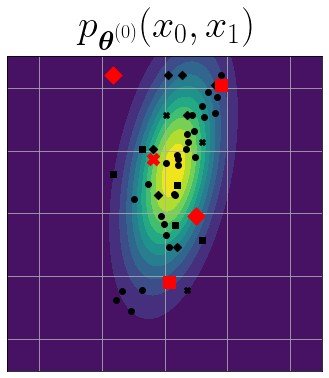

In [24]:
f = plt.figure(figsize=figsize)
ax = f.add_subplot(111)

joint_param = compute_joint(Xk)
plot_joint_density_contours(ax, *joint_param, zorder=0)

# plot_scatter(ax, Xk, M, zorder=10)

plot_scatter(ax, Xk[not_selected], M[not_selected], 
             m0_color='k', 
             m1_color='k', 
             mb_color='k', 
             zorder=10)
# Plot each selected in different color
plot_scatter(ax, Xk[selected], M[selected],  
             zorder=11,
             m0_color='r',
             m1_color='r',
             mb_color='r',
             m_size=scatter_marker_size_big
            )
# selected_colors = ['b', 'g', 'r', 'm', 'c', 'y']
# for i, idx in enumerate(selected):
#     plot_scatter(ax, Xk[selected][i][None, :], M[selected][i][None, :], 
#                  m0_color=selected_colors[i], 
#                  m1_color=selected_colors[i], 
#                  mb_color=selected_colors[i], 
#                  zorder=11)

ax.set_ylim(*ylim)
ax.set_xlim(*xlim)

ax.tick_params(**tick_params)
ax.grid()

ax.set_xlabel(r'$p_{\boldsymbol{\theta}^{(0)}}(x_0, x_1)$', fontsize=big_label_size, labelpad=big_label_pad)
ax.xaxis.set_label_position('top')

ax.set_aspect('equal')

f.tight_layout()
# plt.savefig('figures/step_init.pdf')

### Steps

In [44]:
def plot_joint_step(ax, Xk, M, selected, not_selected, plot_scatter=True):
    joint_param = compute_joint(Xk)
    joint_pdf = plot_joint_density_contours(ax, *joint_param, zorder=0)

    univ_param = compute_univariate_conditionals(Xk, M, *joint_param)
    # plot_univariate_conditionals(ax, Xk, M, *univ_param, *joint_param, 
    #                              joint_pdf=joint_pdf, zorder=10)

    # plot_scatter(ax, Xk, M, zorder=20)
    if plot_scatter:
        plot_scatter(ax, Xk[not_selected], M[not_selected], 
                     m0_color='k', 
                     m1_color='k', 
                     mb_color='k', 
                     zorder=20)
        # Plot each selected in different color
        plot_scatter(ax, Xk[selected], M[selected],  
                     zorder=21,
                     m0_color='r',
                     m1_color='r',
                     mb_color='r',
                     m_size=scatter_marker_size_big,
                     alpha=selected_alpha)
    # selected_colors = ['b', 'g', 'r', 'm', 'c', 'y']
    # for i, idx in enumerate(selected):
    #     plot_scatter(ax, Xk[selected][i][None, :], M[selected][i][None, :], 
    #                  m0_color=selected_colors[i], 
    #                  m1_color=selected_colors[i], 
    #                  mb_color=selected_colors[i], 
    #                  zorder=21)

    ax.set_ylim(*ylim)
    ax.set_xlim(*xlim)
    
    return joint_pdf

#### Step 0

In [26]:
X0 = Xk.copy()

<ipython-input-14-dce7d73994b5>:15: UserWarning: linewidths is ignored by contourf
  contour = ax.contourf(x0, x1, pdf, zorder=zorder,


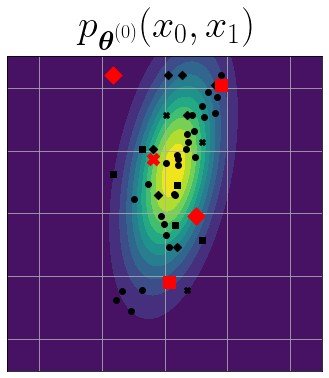

In [27]:
f = plt.figure(figsize=figsize)
ax = f.add_subplot(111)

joint_pdf = plot_joint_step(ax, Xk, M, selected, not_selected)

# legend_handles = [
#     plt.Line2D([], [], marker='.', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
#     plt.Line2D([], [], marker='s', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
#     plt.Line2D([], [], marker='D', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
#     plt.Line2D([], [], marker='X', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
# ]
# legend_labels = [
#     '$(x_0, x_1, x_2)$',
#     '$(?, x_1, x_2)$',
#     '$(x_0, ?, x_2)$',
#     '$(?, ?, x_2)$',
# ]
# ax.legend(labels=legend_labels, handles=legend_handles, fontsize=legend_fontsize)

ax.tick_params(**tick_params) 
ax.grid()
# ax.set_xlabel('$x_0$', fontsize=xy_label_size)
# ax.set_ylabel('$x_1$', fontsize=xy_label_size)
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')
# Make minor ticks larger
# ax.tick_params(which='minor', length=minor_tick_length)

# Add ticks and labels
# hide_major_ticks(ax)
# set_ticks_and_labels(ax, Xk[selected], M[selected])

ax.set_xlabel(r'$p_{\boldsymbol{\theta}^{(0)}}(x_0, x_1)$', fontsize=big_label_size, labelpad=big_label_pad)
ax.xaxis.set_label_position('top')

ax.set_aspect('equal')

f.tight_layout()
# plt.savefig('figures/step_0.pdf')

In [28]:
# f = plt.figure(figsize=figsize)
# ax = f.add_subplot(111)

# joint_param = compute_joint(Xk)
# joint_pdf = plot_joint_density_contours(ax, *joint_param, zorder=2)

# univ_param = compute_univariate_conditionals(Xk, M, *joint_param)
# plot_univariate_conditionals(ax, Xk, M, *univ_param, *joint_param, 
#                              joint_pdf=joint_pdf, zorder=10)

# # plot_scatter(ax, Xk, M, zorder=20)
# full = M.sum(axis=1) == 2
# plot_scatter(ax, Xk[~full], M[~full], 
#              m0_color='k', 
#              m1_color='k', 
#              mb_color='k', 
#              zorder=20)
# # Plot each selected in different color
# plot_scatter(ax, Xk[selected], M[selected],  
#              zorder=21,
#              m0_color='r',
#              m1_color='r',
#              mb_color='r',
#              m_size=scatter_marker_size_big)
# # selected_colors = ['b', 'g', 'r', 'm', 'c', 'y']
# # for i, idx in enumerate(selected):
# #     plot_scatter(ax, Xk[selected][i][None, :], M[selected][i][None, :], 
# #                  m0_color=selected_colors[i], 
# #                  m1_color=selected_colors[i], 
# #                  mb_color=selected_colors[i], 
# #                  zorder=21)

# ax.set_ylim(*ylim)
# ax.set_xlim(*xlim)

# ax.tick_params(**tick_params) 
# ax.grid()
# f.tight_layout()
# # plt.savefig('figures/CDI_example_0.pdf')
# # plt.savefig('figures/CDI_example_0_v7_qjoint.svg')
# # plt.savefig('figures/CDI_example_0_v7_qjoint.png')

##### dim0 univariate pdfs

In [29]:
# f = plt.figure(figsize=(5, 4))

# dim = 0
# obs_dim = 1
# mis_dim = ~M[:, dim]

# # Sort points with missing data in _dim_ by the observed_dim
# Xk_dim0_mis = Xk[mis_dim, :]
# sort_idx = Xk_dim0_mis[:, obs_dim].argsort()[::-1]
# Xk_dim0_mis = Xk_dim0_mis[sort_idx, :]

# M_dim0_mis = M[mis_dim, :]
# M_dim0_mis = M_dim0_mis[sort_idx, :]

# # Sort posterior params
# means_dim0_mis = univ_param[0][mis_dim, :]
# means_dim0_mis = means_dim0_mis[sort_idx, :]
# stds_dim0_mis = univ_param[1][mis_dim, :]
# stds_dim0_mis = stds_dim0_mis[sort_idx, :]

# # indices = [0, 1, 2, 3]
# # indices = [0, 5, 10, 25]
# indices = np.where(np.isin(np.arange(X.shape[0])[mis_dim][sort_idx], selected))[0]  # Select according to _selected_
# # indices = np.arange(3)
# # joint_param = compute_joint(Xk)
# for i, idx in enumerate(indices, 1):
#     ax = f.add_subplot(len(indices), 1, i)

#     plot_univariate_conditional_sideview(ax, dim,
#                                          Xk_dim0_mis[idx], 
#                                          M_dim0_mis[idx],
#                                          means_dim0_mis[idx], 
#                                          stds_dim0_mis[idx],
#                                          *joint_param,
#                                          joint_pdf,
#                                          plot_point=False,
#                                          zorder=5)

#     ax.set_xlim(*xlim)
#     ax.grid()
#     ax.tick_params(**tick_params) 

# f.tight_layout()
# # plt.savefig('figures/step_0_dim0.pdf')

##### dim1 univariate pdfs

In [30]:
# f = plt.figure(figsize=(4, 5))

# dim = 1
# obs_dim = 0
# mis_dim = ~M[:, dim]

# # Sort points with missing data in _dim_ by the observed_dim
# Xk_dim1_mis = Xk[mis_dim, :]
# sort_idx = Xk_dim1_mis[:, obs_dim].argsort()#[::-1]
# Xk_dim1_mis = Xk_dim1_mis[sort_idx, :]

# M_dim1_mis = M[mis_dim, :]
# M_dim1_mis = M_dim1_mis[sort_idx, :]

# # Sort posterior params
# means_dim1_mis = univ_param[0][mis_dim, :]
# means_dim1_mis = means_dim1_mis[sort_idx, :]
# stds_dim1_mis = univ_param[1][mis_dim, :]
# stds_dim1_mis = stds_dim1_mis[sort_idx, :]

# # indices = [0, 1, 2, 3, 4, 5]
# # indices = [0, 5, 10, 20, 22]
# indices = np.where(np.isin(np.arange(X.shape[0])[mis_dim][sort_idx], selected))[0]  # Select according to _selected_
# # indices = np.arange(3)
# # joint_param0 = compute_joint(X0)
# for i, idx in enumerate(indices, 1):
#     ax = f.add_subplot(1, len(indices), i)

#     plot_univariate_conditional_sideview(ax, dim, 
#                                          Xk_dim1_mis[idx], 
#                                          M_dim1_mis[idx],
#                                          means_dim1_mis[idx], 
#                                          stds_dim1_mis[idx],
#                                          *joint_param, 
#                                          joint_pdf,
#                                          plot_point=False)

#     ax.set_ylim(*ylim)
#     ax.grid()
#     ax.tick_params(**tick_params) 

# f.tight_layout()
# # f.subplots_adjust(wspace=0.3, hspace=None)

# # plt.savefig('figures/step_0_dim1.pdf')

#### Step 1

In [31]:
Xk_bck = Xk.copy()
joint_param = compute_joint(Xk)
univ_param = compute_univariate_conditionals(Xk, M, *joint_param)
Xk = impute_with_conditional_samples(Xk, M, *univ_param, repeat=10)
X1 = Xk.copy()

<ipython-input-14-dce7d73994b5>:15: UserWarning: linewidths is ignored by contourf
  contour = ax.contourf(x0, x1, pdf, zorder=zorder,


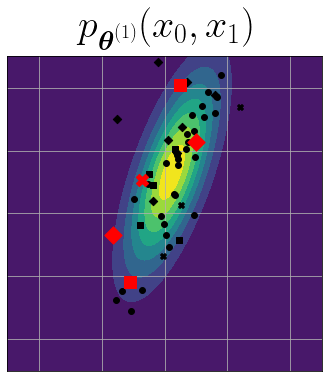

In [32]:
f = plt.figure(figsize=figsize)
ax = f.add_subplot(111)

joint_pdf = plot_joint_step(ax, Xk, M, selected, not_selected)

# joint_param = compute_joint(Xk)
# univ_param = compute_univariate_conditionals(Xk, M, *joint_param)
# plot_univariate_conditionals(ax, Xk, M, *univ_param, *joint_param, 
#                              joint_pdf=joint_pdf, zorder=10)

# plot_scatter(ax, Xk_bck[selected], M[selected], 
#                  m0_color='r', 
#                  m1_color='r', 
#                  mb_color='r', 
#                  zorder=20,
#                  m_size=scatter_marker_size_big,
#                  linewidth=1,
#                  alpha=prev_scatter_alpha)

# legend_handles = [
#     plt.Line2D([], [], marker='.', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
#     plt.Line2D([], [], marker='s', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
#     plt.Line2D([], [], marker='D', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
#     plt.Line2D([], [], marker='x', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
# ]
# legend_labels = [
#     '$(x_0, x_1, x_2)$',
#     '$(?, x_1, x_2)$',
#     '$(x_0, ?, x_2)$',
#     '$(?, ?, x_2)$',
# ]
# ax.legend(labels=legend_labels, handles=legend_handles, fontsize=legend_fontsize)

ax.tick_params(**tick_params) 
ax.grid()
# ax.set_xlabel('$x_0$', fontsize=xy_label_size)
# ax.set_ylabel('$x_1$', fontsize=xy_label_size)
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')
# ax.yaxis.set_label_position('right')
# ax.yaxis.tick_right()
# Make minor ticks larger
# ax.tick_params(which='minor', length=minor_tick_length)

# Add ticks and labels
# hide_major_ticks(ax)
# set_ticks_and_labels(ax, Xk[selected], M[selected])

ax.set_xlabel(r'$p_{\boldsymbol{\theta}^{(1)}}(x_0, x_1)$', fontsize=big_label_size, labelpad=big_label_pad)
ax.xaxis.set_label_position('top')

ax.set_aspect('equal')

f.tight_layout()
# plt.savefig('figures/step_1.pdf')

##### dim0 univariate pdfs

In [33]:
# f = plt.figure(figsize=(5, 4))

# dim = 0
# obs_dim = 1
# mis_dim = ~M[:, dim]

# # Sort points with missing data in _dim_ by the observed_dim
# Xk_dim0_mis = Xk[mis_dim, :]
# sort_idx = Xk_dim0_mis[:, obs_dim].argsort()[::-1]
# Xk_dim0_mis = Xk_dim0_mis[sort_idx, :]

# M_dim0_mis = M[mis_dim, :]
# M_dim0_mis = M_dim0_mis[sort_idx, :]

# # Sort posterior params
# means_dim0_mis = univ_param[0][mis_dim, :]
# means_dim0_mis = means_dim0_mis[sort_idx, :]
# stds_dim0_mis = univ_param[1][mis_dim, :]
# stds_dim0_mis = stds_dim0_mis[sort_idx, :]

# # indices = [0, 1, 2, 3]
# # indices = [0, 5, 10, 25]
# # indices = np.arange(3)
# indices = np.where(np.isin(np.arange(X.shape[0])[mis_dim][sort_idx], selected))[0]  # Select according to _selected_
# joint_param = compute_joint(Xk)
# for i, idx in enumerate(indices, 1):
#     ax = f.add_subplot(len(indices), 1, i)
    
#     plot_univariate_conditional_sideview(ax, dim, 
#                                          Xk_dim0_mis[idx], 
#                                          M_dim0_mis[idx],
#                                          means_dim0_mis[idx], 
#                                          stds_dim0_mis[idx],
#                                          *joint_param,
#                                          joint_pdf,
#                                          plot_point=False, 
#                                          zorder=5)

#     ax.set_xlim(*xlim)
#     ax.grid()
#     ax.tick_params(**tick_params) 

# f.tight_layout()
# # plt.savefig('figures/CDI_example_1_dim0.pdf')
# # plt.savefig('figures/CDI_example_1_dim0_v6.svg')

##### dim1 univariate pdfs

In [34]:
# f = plt.figure(figsize=(4, 5))

# dim = 1
# obs_dim = 0
# mis_dim = ~M[:, dim]

# # Sort points with missing data in _dim_ by the observed_dim
# Xk_dim1_mis = Xk[mis_dim, :]
# sort_idx = Xk_dim1_mis[:, obs_dim].argsort()#[::-1]
# Xk_dim1_mis = Xk_dim1_mis[sort_idx, :]

# M_dim1_mis = M[mis_dim, :]
# M_dim1_mis = M_dim1_mis[sort_idx, :]

# # Sort posterior params
# means_dim1_mis = univ_param[0][mis_dim, :]
# means_dim1_mis = means_dim1_mis[sort_idx, :]
# stds_dim1_mis = univ_param[1][mis_dim, :]
# stds_dim1_mis = stds_dim1_mis[sort_idx, :]

# # indices = [0, 1, 2, 3, 4, 5]
# # indices = [0, 5, 10, 20, 22]
# # indices = np.arange(3)
# indices = np.where(np.isin(np.arange(X.shape[0])[mis_dim][sort_idx], selected))[0]  # Select according to _selected_
# joint_param = compute_joint(Xk)
# for i, idx in enumerate(indices, 1):
#     ax = f.add_subplot(1, len(indices), i)

#     plot_univariate_conditional_sideview(ax, dim, 
#                                          Xk_dim1_mis[idx], 
#                                          M_dim1_mis[idx],
#                                          means_dim1_mis[idx], 
#                                          stds_dim1_mis[idx],
#                                          *joint_param, 
#                                          joint_pdf,
#                                          plot_point=False, 
#                                          zorder=5)

#     ax.set_ylim(*ylim)
#     ax.grid()
#     ax.tick_params(**tick_params) 

# f.tight_layout()
# # plt.savefig('figures/CDI_example_1_dim1.pdf')
# # plt.savefig('figures/CDI_example_1_dim1_6.svg')

#### Step 0 & 1 in one fig

<ipython-input-14-dce7d73994b5>:15: UserWarning: linewidths is ignored by contourf
  contour = ax.contourf(x0, x1, pdf, zorder=zorder,


Text(0.71, 0.01, '$p_{\\boldsymbol{\\theta}^{(1)}}(x_0, x_1)$')

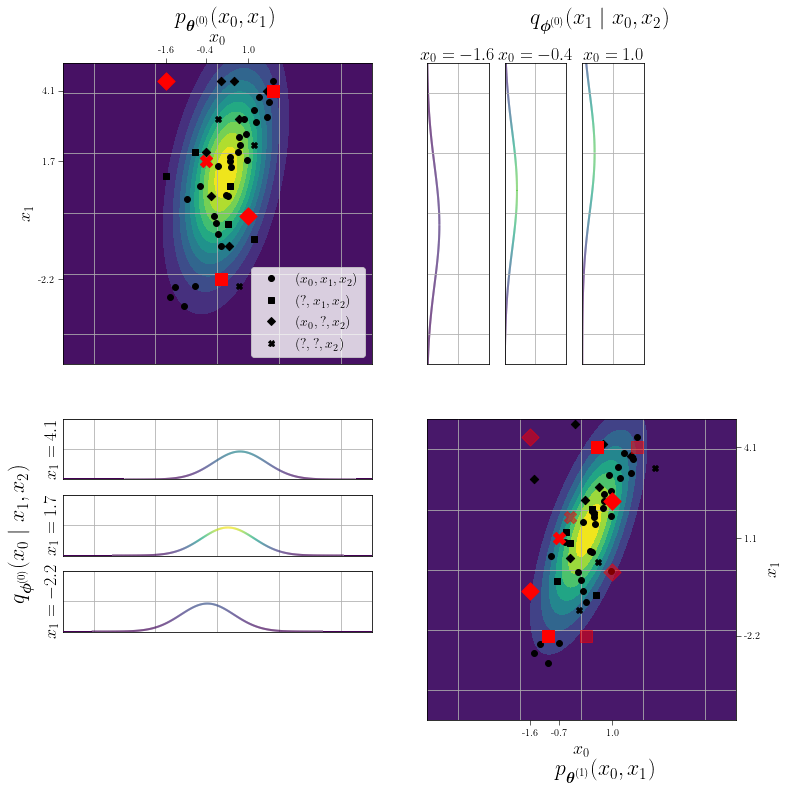

In [35]:
f = plt.figure(figsize=(11, 11))

# Set rectangle sizes
left = 0.09
bottom = 0.08
width = 0.39
height = 0.38
wgap = 0.07
hgap = 0.07
side_width = width/5
side_height = height/5
side_wgap = 0.02
side_hgap = 0.02

# plot 1
rect1 = [left, bottom+height+hgap, width, height]
rect2 = [left+width+wgap, bottom+height+hgap, side_width, height]
rect3 = [left+width+wgap+side_width*1+side_wgap*1, bottom+height+hgap, side_width, height]
rect4 = [left+width+wgap+side_width*2+side_wgap*2, bottom+height+hgap, side_width, height]
rect5 = [left, bottom+height-side_height*1, width, side_height*1]
rect6 = [left, bottom+height-side_height*2-side_hgap*1, width, side_height]
rect7 = [left, bottom+height-side_height*3-side_hgap*2, width, side_height]
rect8 = [left+width+wgap, bottom, width, height]

################# TOP-LEFT
ax1 = f.add_axes(rect1)

joint_pdf0 = plot_joint_step(ax1, X0, M, selected, not_selected)

legend_handles = [
    plt.Line2D([], [], marker='o', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
    plt.Line2D([], [], marker='s', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
    plt.Line2D([], [], marker='D', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
    plt.Line2D([], [], marker='X', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
]
legend_labels = [
    '$(x_0, x_1, x_2)$',
    '$(?, x_1, x_2)$',
    '$(x_0, ?, x_2)$',
    '$(?, ?, x_2)$',
]
ax1.legend(labels=legend_labels, handles=legend_handles, fontsize=legend_fontsize)

# ax.tick_params(**tick_params) 
ax1.grid()
ax1.set_xlabel('$x_0$', fontsize=xy_label_size)
ax1.set_ylabel('$x_1$', fontsize=xy_label_size)
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
# Make minor ticks larger
ax1.tick_params(which='minor', length=minor_tick_length)

# Add ticks and labels
hide_major_ticks(ax1)
set_ticks_and_labels(ax1, X0[selected], M[selected])


################# BOTTOM-RIGHT
ax8 = f.add_axes(rect8)

joint_pdf1 = plot_joint_step(ax8, X1, M, selected, not_selected)

# Plot previour imputations with transparency
plot_scatter(ax8, X0[selected], M[selected], 
                 m0_color='r', 
                 m1_color='r', 
                 mb_color='r', 
                 zorder=20,
                 m_size=scatter_marker_size_big,
                 linewidth=1,
                 alpha=prev_scatter_alpha)

# legend_handles = [
#     plt.Line2D([], [], marker='.', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
#     plt.Line2D([], [], marker='s', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
#     plt.Line2D([], [], marker='D', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
#     plt.Line2D([], [], marker='x', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
# ]
# legend_labels = [
#     '$(x_0, x_1, x_2)$',
#     '$(?, x_1, x_2)$',
#     '$(x_0, ?, x_2)$',
#     '$(?, ?, x_2)$',
# ]
# ax8.legend(labels=legend_labels, handles=legend_handles, fontsize=legend_fontsize)

# ax8.tick_params(**tick_params) 
ax8.grid()
ax8.set_xlabel('$x_0$', fontsize=xy_label_size)
ax8.set_ylabel('$x_1$', fontsize=xy_label_size)
# ax8.xaxis.tick_top()
# ax8.xaxis.set_label_position('top')
ax8.yaxis.set_label_position('right')
ax8.yaxis.tick_right()
# Make minor ticks larger
ax8.tick_params(which='minor', length=minor_tick_length)

# Add ticks and labels
hide_major_ticks(ax8)
set_ticks_and_labels(ax8, X1[selected], M[selected])

################# Dim 1
ax2 = f.add_axes(rect2)
ax3 = f.add_axes(rect3)
ax4 = f.add_axes(rect4)

dim = 1
obs_dim = 0
mis_dim = ~M[:, dim]

# Sort points with missing data in _dim_ by the observed_dim
X0_dim1_mis = X0[mis_dim, :]
sort_idx = X0_dim1_mis[:, obs_dim].argsort()#[::-1]
X0_dim1_mis = X0_dim1_mis[sort_idx, :]

M_dim1_mis = M[mis_dim, :]
M_dim1_mis = M_dim1_mis[sort_idx, :]

# Sort posterior params
means_dim1_mis = univ_param[0][mis_dim, :]
means_dim1_mis = means_dim1_mis[sort_idx, :]
stds_dim1_mis = univ_param[1][mis_dim, :]
stds_dim1_mis = stds_dim1_mis[sort_idx, :]

joint_param0 = compute_joint(X0)
indices = np.where(np.isin(np.arange(X.shape[0])[mis_dim][sort_idx], selected))[0]  # Select according to _selected_
for i, idx in enumerate(indices, 0):
    ax = [ax2, ax3, ax4][i]

    plot_univariate_conditional_sideview(ax, dim, 
                                         X0_dim1_mis[idx], 
                                         M_dim1_mis[idx],
                                         means_dim1_mis[idx], 
                                         stds_dim1_mis[idx],
                                         *joint_param0, 
                                         joint_pdf0,
                                         plot_point=False)

    ax.set_ylim(*ylim)
    ax.grid()
    ax.tick_params(**tick_params) 

################# Dim 0
ax5 = f.add_axes(rect5)
ax6 = f.add_axes(rect6)
ax7 = f.add_axes(rect7)

dim = 0
obs_dim = 1
mis_dim = ~M[:, dim]

# Sort points with missing data in _dim_ by the observed_dim
X0_dim0_mis = X0[mis_dim, :]
sort_idx = X0_dim0_mis[:, obs_dim].argsort()[::-1]
X0_dim0_mis = X0_dim0_mis[sort_idx, :]

M_dim0_mis = M[mis_dim, :]
M_dim0_mis = M_dim0_mis[sort_idx, :]

# Sort posterior params
means_dim0_mis = univ_param[0][mis_dim, :]
means_dim0_mis = means_dim0_mis[sort_idx, :]
stds_dim0_mis = univ_param[1][mis_dim, :]
stds_dim0_mis = stds_dim0_mis[sort_idx, :]

indices = np.where(np.isin(np.arange(X.shape[0])[mis_dim][sort_idx], selected))[0]  # Select according to _selected_
for i, idx in enumerate(indices, 0):
    ax = [ax5, ax6, ax7][i]

    plot_univariate_conditional_sideview(ax, dim,
                                         X0_dim0_mis[idx], 
                                         M_dim0_mis[idx],
                                         means_dim0_mis[idx], 
                                         stds_dim0_mis[idx],
                                         *joint_param0,
                                         joint_pdf0,
                                         plot_point=False,
                                         zorder=5)

    ax.set_xlim(*xlim)
    ax.grid()
    ax.tick_params(**tick_params) 

    
f.text(x=0.23, y=0.96, s=r'$p_{\boldsymbol{\theta}^{(0)}}(x_0, x_1)$',
       fontdict={'family' : 'normal', 'weight' : 'bold', 'size' : med_label_size})
f.text(x=0.68, y=0.96, s=r'$q_{\boldsymbol{\phi}^{(0)}}(x_1 \mid x_0, x_2)$',
       fontdict={'family' : 'normal', 'weight' : 'bold', 'size' : med_label_size})
f.text(x=0.02, y=0.24, s=r'$q_{\boldsymbol{\phi}^{(0)}}(x_0 \mid x_1, x_2)$', rotation=90,
       fontdict={'family' : 'normal', 'weight' : 'bold', 'size' : med_label_size})
f.text(x=0.71, y=0.01, s=r'$p_{\boldsymbol{\theta}^{(1)}}(x_0, x_1)$',
       fontdict={'family' : 'normal', 'weight' : 'bold', 'size' : med_label_size})

# f.tight_layout()
# plt.savefig('figures/steps_01_dissect.pdf')

#### Only transitions at 0

<ipython-input-14-dce7d73994b5>:15: UserWarning: linewidths is ignored by contourf
  contour = ax.contourf(x0, x1, pdf, zorder=zorder,


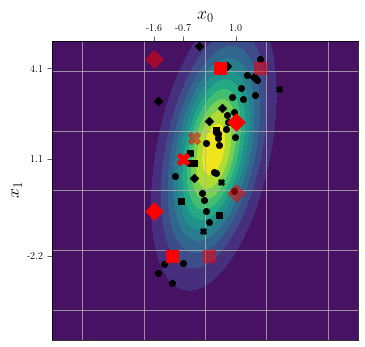

In [63]:
fig, ax = plt.subplots(figsize=(5.5,5.5))

joint_pdf0 = plot_joint_step(ax, X0, M, selected, not_selected, plot_scatter=False)

plot_scatter(ax, X1[not_selected], M[not_selected], 
                 m0_color='k', 
                 m1_color='k', 
                 mb_color='k',
                 zorder=20,
#                  m_size=scatter_marker_size_big,
                 linewidth=1)

plot_scatter(ax, X0[selected], M[selected], 
                 m0_color='r', 
                 m1_color='r', 
                 mb_color='r', 
                 zorder=20,
                 m_size=scatter_marker_size_big,
                 linewidth=1,
                 alpha=prev_scatter_alpha)

plot_scatter(ax, X1[selected], M[selected], 
                 m0_color='r', 
                 m1_color='r', 
                 mb_color='r', 
                 zorder=20,
                 m_size=scatter_marker_size_big,
                 linewidth=1)

ax.grid()
ax.set_xlabel('$x_0$', fontsize=xy_label_size)
ax.set_ylabel('$x_1$', fontsize=xy_label_size)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
# Make minor ticks larger
ax.tick_params(which='minor', length=minor_tick_length)
# Add ticks and labels
hide_major_ticks(ax)
set_ticks_and_labels(ax, X1[selected], M[selected])

plt.savefig('figures/steps_1_preimp.pdf')

#### Step 2

In [37]:
Xk_bck = Xk.copy()
joint_param = compute_joint(Xk)
univ_param = compute_univariate_conditionals(Xk, M, *joint_param)
Xk = impute_with_conditional_samples(Xk, M, *univ_param, repeat=13)
X2 = Xk.copy()

<ipython-input-17-dce7d73994b5>:15: UserWarning: linewidths is ignored by contourf
  contour = ax.contourf(x0, x1, pdf, zorder=zorder,


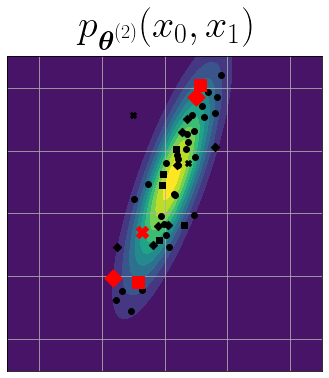

In [38]:
f = plt.figure(figsize=figsize)
ax = f.add_subplot(111)

plot_joint_step(ax, Xk, M, selected, not_selected)

# plot_scatter(ax, Xk_bck[selected], M[selected], 
#                  m0_color='r', 
#                  m1_color='r', 
#                  mb_color='r', 
#                  zorder=20,
#                  m_size=scatter_marker_size_big,
#                  linewidth=1,
#                  alpha=prev_scatter_alpha)

# legend_handles = [
#     plt.Line2D([], [], marker='.', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
#     plt.Line2D([], [], marker='s', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
#     plt.Line2D([], [], marker='D', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
#     plt.Line2D([], [], marker='x', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
# ]
# legend_labels = [
#     '$(x_0, x_1, x_2)$',
#     '$(?, x_1, x_2)$',
#     '$(x_0, ?, x_2)$',
#     '$(?, ?, x_2)$',
# ]
# ax.legend(labels=legend_labels, handles=legend_handles, fontsize=legend_fontsize)

ax.tick_params(**tick_params) 
ax.grid()
# ax.set_xlabel('$x_0$', fontsize=xy_label_size)
# ax.set_ylabel('$x_1$', fontsize=xy_label_size)
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')
# ax.yaxis.set_label_position('right')
# ax.yaxis.tick_right()
# Make minor ticks larger
# ax.tick_params(which='minor', length=minor_tick_length)

# Add ticks and labels
# hide_major_ticks(ax)
# set_ticks_and_labels(ax, Xk[selected], M[selected])

ax.set_xlabel(r'$p_{\boldsymbol{\theta}^{(2)}}(x_0, x_1)$', fontsize=big_label_size, labelpad=big_label_pad)
ax.xaxis.set_label_position('top')

ax.set_aspect('equal')

f.tight_layout()
# plt.savefig('figures/step_2.pdf')

#### Step 1 & 2 in one fig

<ipython-input-17-dce7d73994b5>:15: UserWarning: linewidths is ignored by contourf
  contour = ax.contourf(x0, x1, pdf, zorder=zorder,


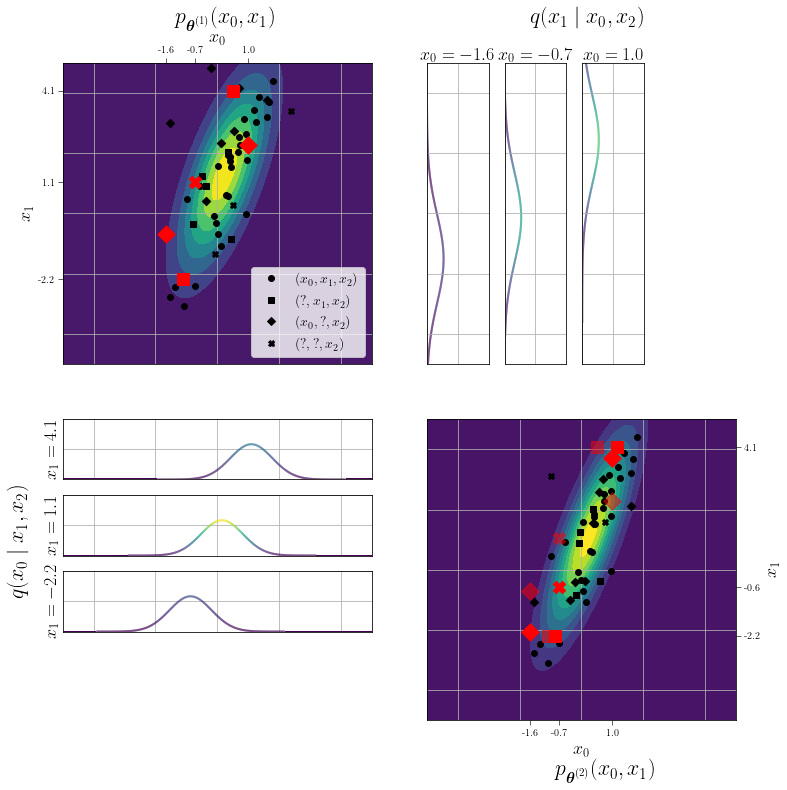

In [42]:
f = plt.figure(figsize=(11, 11))

# Set rectangle sizes
left = 0.09
bottom = 0.08
width = 0.39
height = 0.38
wgap = 0.07
hgap = 0.07
side_width = width/5
side_height = height/5
side_wgap = 0.02
side_hgap = 0.02

# plot 1
rect1 = [left, bottom+height+hgap, width, height]
rect2 = [left+width+wgap, bottom+height+hgap, side_width, height]
rect3 = [left+width+wgap+side_width*1+side_wgap*1, bottom+height+hgap, side_width, height]
rect4 = [left+width+wgap+side_width*2+side_wgap*2, bottom+height+hgap, side_width, height]
rect5 = [left, bottom+height-side_height*1, width, side_height*1]
rect6 = [left, bottom+height-side_height*2-side_hgap*1, width, side_height]
rect7 = [left, bottom+height-side_height*3-side_hgap*2, width, side_height]
rect8 = [left+width+wgap, bottom, width, height]

################# TOP-LEFT
ax1 = f.add_axes(rect1)

joint_pdf1 = plot_joint_step(ax1, X1, M, selected, not_selected)

legend_handles = [
    plt.Line2D([], [], marker='o', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
    plt.Line2D([], [], marker='s', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
    plt.Line2D([], [], marker='D', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
    plt.Line2D([], [], marker='X', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
]
legend_labels = [
    '$(x_0, x_1, x_2)$',
    '$(?, x_1, x_2)$',
    '$(x_0, ?, x_2)$',
    '$(?, ?, x_2)$',
]
ax1.legend(labels=legend_labels, handles=legend_handles, fontsize=legend_fontsize)

# ax.tick_params(**tick_params) 
ax1.grid()
ax1.set_xlabel('$x_0$', fontsize=xy_label_size)
ax1.set_ylabel('$x_1$', fontsize=xy_label_size)
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
# Make minor ticks larger
ax1.tick_params(which='minor', length=minor_tick_length)

# Add ticks and labels
hide_major_ticks(ax1)
set_ticks_and_labels(ax1, X1[selected], M[selected])


################# BOTTOM-RIGHT
ax8 = f.add_axes(rect8)

joint_pdf2 = plot_joint_step(ax8, X2, M, selected, not_selected)

# Plot previour imputations with transparency
plot_scatter(ax8, X1[selected], M[selected], 
                 m0_color='r', 
                 m1_color='r', 
                 mb_color='r', 
                 zorder=20,
                 m_size=scatter_marker_size_big,
                 linewidth=1,
                 alpha=prev_scatter_alpha)

# legend_handles = [
#     plt.Line2D([], [], marker='.', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
#     plt.Line2D([], [], marker='s', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
#     plt.Line2D([], [], marker='D', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
#     plt.Line2D([], [], marker='x', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
# ]
# legend_labels = [
#     '$(x_0, x_1, x_2)$',
#     '$(?, x_1, x_2)$',
#     '$(x_0, ?, x_2)$',
#     '$(?, ?, x_2)$',
# ]
# ax8.legend(labels=legend_labels, handles=legend_handles, fontsize=legend_fontsize)

# ax8.tick_params(**tick_params) 
ax8.grid()
ax8.set_xlabel('$x_0$', fontsize=xy_label_size)
ax8.set_ylabel('$x_1$', fontsize=xy_label_size)
# ax8.xaxis.tick_top()
# ax8.xaxis.set_label_position('top')
ax8.yaxis.set_label_position('right')
ax8.yaxis.tick_right()
# Make minor ticks larger
ax8.tick_params(which='minor', length=minor_tick_length)

# Add ticks and labels
hide_major_ticks(ax8)
set_ticks_and_labels(ax8, X2[selected], M[selected])

################# Dim 1
ax2 = f.add_axes(rect2)
ax3 = f.add_axes(rect3)
ax4 = f.add_axes(rect4)

dim = 1
obs_dim = 0
mis_dim = ~M[:, dim]

# Sort points with missing data in _dim_ by the observed_dim
X1_dim1_mis = X1[mis_dim, :]
sort_idx = X1_dim1_mis[:, obs_dim].argsort()#[::-1]
X1_dim1_mis = X1_dim1_mis[sort_idx, :]

M_dim1_mis = M[mis_dim, :]
M_dim1_mis = M_dim1_mis[sort_idx, :]

# Sort posterior params
means_dim1_mis = univ_param[0][mis_dim, :]
means_dim1_mis = means_dim1_mis[sort_idx, :]
stds_dim1_mis = univ_param[1][mis_dim, :]
stds_dim1_mis = stds_dim1_mis[sort_idx, :]

joint_param1 = compute_joint(X1)
indices = np.where(np.isin(np.arange(X.shape[0])[mis_dim][sort_idx], selected))[0]  # Select according to _selected_
for i, idx in enumerate(indices, 0):
    ax = [ax2, ax3, ax4][i]

    plot_univariate_conditional_sideview(ax, dim, 
                                         X1_dim1_mis[idx], 
                                         M_dim1_mis[idx],
                                         means_dim1_mis[idx], 
                                         stds_dim1_mis[idx],
                                         *joint_param1, 
                                         joint_pdf1,
                                         plot_point=False)

    ax.set_ylim(*ylim)
    ax.grid()
    ax.tick_params(**tick_params) 

################# Dim 0
ax5 = f.add_axes(rect5)
ax6 = f.add_axes(rect6)
ax7 = f.add_axes(rect7)

dim = 0
obs_dim = 1
mis_dim = ~M[:, dim]

# Sort points with missing data in _dim_ by the observed_dim
X1_dim0_mis = X1[mis_dim, :]
sort_idx = X1_dim0_mis[:, obs_dim].argsort()[::-1]
X1_dim0_mis = X1_dim0_mis[sort_idx, :]

M_dim0_mis = M[mis_dim, :]
M_dim0_mis = M_dim0_mis[sort_idx, :]

# Sort posterior params
means_dim0_mis = univ_param[0][mis_dim, :]
means_dim0_mis = means_dim0_mis[sort_idx, :]
stds_dim0_mis = univ_param[1][mis_dim, :]
stds_dim0_mis = stds_dim0_mis[sort_idx, :]

indices = np.where(np.isin(np.arange(X.shape[0])[mis_dim][sort_idx], selected))[0]  # Select according to _selected_
for i, idx in enumerate(indices, 0):
    ax = [ax5, ax6, ax7][i]

    plot_univariate_conditional_sideview(ax, dim,
                                         X1_dim0_mis[idx], 
                                         M_dim0_mis[idx],
                                         means_dim0_mis[idx], 
                                         stds_dim0_mis[idx],
                                         *joint_param1,
                                         joint_pdf1,
                                         plot_point=False,
                                         zorder=5)

    ax.set_xlim(*xlim)
    ax.grid()
    ax.tick_params(**tick_params) 

    
f.text(x=0.23, y=0.96, s=r'$p_{\boldsymbol{\theta}^{(1)}}(x_0, x_1)$',
       fontdict={'family' : 'normal', 'weight' : 'bold', 'size' : med_label_size})
f.text(x=0.68, y=0.96, s="$q(x_1 \mid x_0, x_2)$",
       fontdict={'family' : 'normal', 'weight' : 'bold', 'size' : med_label_size})
f.text(x=0.02, y=0.24, s="$q(x_0 \mid x_1, x_2)$", rotation=90,
       fontdict={'family' : 'normal', 'weight' : 'bold', 'size' : med_label_size})
f.text(x=0.71, y=0.01, s=r'$p_{\boldsymbol{\theta}^{(2)}}(x_0, x_1)$',
       fontdict={'family' : 'normal', 'weight' : 'bold', 'size' : med_label_size})

# f.tight_layout()
# plt.savefig('figures/steps_12_dissect.pdf')

#### Step 3

In [43]:
Xk_bck = Xk.copy()
joint_param = compute_joint(Xk)
univ_param = compute_univariate_conditionals(Xk, M, *joint_param)
Xk = impute_with_conditional_samples(Xk, M, *univ_param, repeat=8)
X3 = Xk.copy()

In [ ]:
# f = plt.figure(figsize=figsize)
# ax = f.add_subplot(111)

# plot_joint_step(ax, Xk, M, selected, not_selected)

# # plot_scatter(ax, Xk_bck[selected], M[selected], 
# #                  m0_color='r', 
# #                  m1_color='r', 
# #                  mb_color='r', 
# #                  zorder=20,
# #                  m_size=scatter_marker_size_big,
# #                  linewidth=1,
# #                  alpha=prev_scatter_alpha)

# # legend_handles = [
# #     plt.Line2D([], [], marker='.', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
# #     plt.Line2D([], [], marker='s', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
# #     plt.Line2D([], [], marker='D', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
# #     plt.Line2D([], [], marker='x', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
# # ]
# # legend_labels = [
# #     '$(x_0, x_1, x_2)$',
# #     '$(?, x_1, x_2)$',
# #     '$(x_0, ?, x_2)$',
# #     '$(?, ?, x_2)$',
# # ]
# # ax.legend(labels=legend_labels, handles=legend_handles, fontsize=legend_fontsize)

# ax.tick_params(**tick_params) 
# ax.grid()
# # ax.set_xlabel('$x_0$', fontsize=xy_label_size)
# # ax.set_ylabel('$x_1$', fontsize=xy_label_size)
# # ax.xaxis.tick_top()
# # ax.xaxis.set_label_position('top')
# # ax.yaxis.set_label_position('right')
# # ax.yaxis.tick_right()
# # Make minor ticks larger
# # ax.tick_params(which='minor', length=minor_tick_length)

# # Add ticks and labels
# # hide_major_ticks(ax)
# # set_ticks_and_labels(ax, Xk[selected], M[selected])

# ax.set_xlabel(r'$p_{\boldsymbol{\theta}^{(3)}}(x_0, x_1)$', fontsize=big_label_size, labelpad=big_label_pad)
# ax.xaxis.set_label_position('top')

# ax.set_aspect('equal')

# f.tight_layout()
# # plt.savefig('figures/step_3.pdf')

#### Step 4

In [44]:
Xk_bck = Xk.copy()
joint_param = compute_joint(Xk)
univ_param = compute_univariate_conditionals(Xk, M, *joint_param)
Xk = impute_with_conditional_samples(Xk, M, *univ_param, repeat=8)
X4 = Xk.copy()

In [ ]:
# f = plt.figure(figsize=figsize)
# ax = f.add_subplot(111)

# plot_joint_step(ax, Xk, M, selected, not_selected)

# # plot_scatter(ax, Xk_bck[selected], M[selected], 
# #                  m0_color='r', 
# #                  m1_color='r', 
# #                  mb_color='r', 
# #                  zorder=20,
# #                  m_size=scatter_marker_size_big,
# #                  linewidth=1,
# #                  alpha=prev_scatter_alpha)

# # legend_handles = [
# #     plt.Line2D([], [], marker='.', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
# #     plt.Line2D([], [], marker='s', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
# #     plt.Line2D([], [], marker='D', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
# #     plt.Line2D([], [], marker='x', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
# # ]
# # legend_labels = [
# #     '$(x_0, x_1, x_2)$',
# #     '$(?, x_1, x_2)$',
# #     '$(x_0, ?, x_2)$',
# #     '$(?, ?, x_2)$',
# # ]
# # ax.legend(labels=legend_labels, handles=legend_handles, fontsize=legend_fontsize)

# ax.tick_params(**tick_params) 
# ax.grid()
# # ax.set_xlabel('$x_0$', fontsize=xy_label_size)
# # ax.set_ylabel('$x_1$', fontsize=xy_label_size)
# # ax.xaxis.tick_top()
# # ax.xaxis.set_label_position('top')
# # ax.yaxis.set_label_position('right')
# # ax.yaxis.tick_right()
# # Make minor ticks larger
# # ax.tick_params(which='minor', length=minor_tick_length)

# # Add ticks and labels
# # hide_major_ticks(ax)
# # set_ticks_and_labels(ax, Xk[selected], M[selected])

# ax.set_xlabel(r'$p_{\boldsymbol{\theta}^{(4)}}(x_0, x_1)$', fontsize=big_label_size, labelpad=big_label_pad)
# ax.xaxis.set_label_position('top')

# ax.set_aspect('equal')

# f.tight_layout()
# # plt.savefig('figures/step_4.pdf')

#### Step 10

In [45]:
for _ in range(7):
    joint_param = compute_joint(Xk)
    univ_param = compute_univariate_conditionals(Xk, M, *joint_param)
    Xk = impute_with_conditional_samples(Xk, M, *univ_param, repeat=8)

<ipython-input-17-dce7d73994b5>:15: UserWarning: linewidths is ignored by contourf
  contour = ax.contourf(x0, x1, pdf, zorder=zorder,


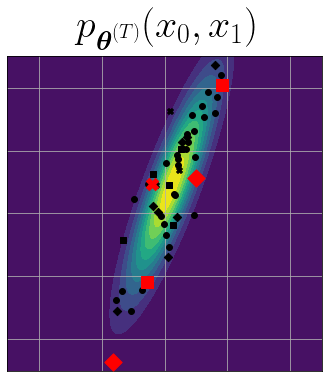

In [47]:
f = plt.figure(figsize=figsize)
ax = f.add_subplot(111)

plot_joint_step(ax, Xk, M, selected, not_selected)

# plot_scatter(ax, Xk_bck[selected], M[selected], 
#                  m0_color='r', 
#                  m1_color='r', 
#                  mb_color='r', 
#                  zorder=20,
#                  m_size=scatter_marker_size_big,
#                  linewidth=1,
#                  alpha=prev_scatter_alpha)

# legend_handles = [
#     plt.Line2D([], [], marker='.', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
#     plt.Line2D([], [], marker='s', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
#     plt.Line2D([], [], marker='D', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
#     plt.Line2D([], [], marker='x', color='k', linestyle='', linewidth=line_linewidth, markeredgewidth=scatter_linewidth),
# ]
# legend_labels = [
#     '$(x_0, x_1, x_2)$',
#     '$(?, x_1, x_2)$',
#     '$(x_0, ?, x_2)$',
#     '$(?, ?, x_2)$',
# ]
# ax.legend(labels=legend_labels, handles=legend_handles, fontsize=legend_fontsize)

ax.tick_params(**tick_params) 
ax.grid()
# ax.set_xlabel('$x_0$', fontsize=xy_label_size)
# ax.set_ylabel('$x_1$', fontsize=xy_label_size)
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')
# ax.yaxis.set_label_position('right')
# ax.yaxis.tick_right()
# Make minor ticks larger
# ax.tick_params(which='minor', length=minor_tick_length)

# Add ticks and labels
# hide_major_ticks(ax)
# set_ticks_and_labels(ax, Xk[selected], M[selected])

ax.set_xlabel(r'$p_{\boldsymbol{\theta}^{(T)}}(x_0, x_1)$', fontsize=big_label_size, labelpad=big_label_pad)
ax.xaxis.set_label_position('top')

ax.set_aspect('equal')

f.tight_layout()
# plt.savefig('figures/step_T.pdf')

##### dim0 univariate pdfs

In [ ]:
# f = plt.figure(figsize=(5, 3))

# dim = 0
# obs_dim = 1
# mis_dim = ~M[:, dim]

# # Sort points with missing data in _dim_ by the observed_dim
# Xk_dim0_mis = Xk[mis_dim, :]
# sort_idx = Xk_dim0_mis[:, obs_dim].argsort()[::-1]
# Xk_dim0_mis = Xk_dim0_mis[sort_idx, :]

# M_dim0_mis = M[mis_dim, :]
# M_dim0_mis = M_dim0_mis[sort_idx, :]

# # Sort posterior params
# means_dim0_mis = univ_param[0][mis_dim, :]
# means_dim0_mis = means_dim0_mis[sort_idx, :]
# stds_dim0_mis = univ_param[1][mis_dim, :]
# stds_dim0_mis = stds_dim0_mis[sort_idx, :]

# # indices = [0, 1, 2, 3]
# # indices = [0, 5, 10, 25]
# indices = np.arange(3)
# for i, idx in enumerate(indices, 1):
#     ax = f.add_subplot(len(indices), 1, i)
    
#     plot_univariate_conditional_sideview(ax, dim, 
#                                          Xk_dim0_mis[idx], 
#                                          M_dim0_mis[idx],
#                                          means_dim0_mis[idx], 
#                                          stds_dim0_mis[idx],
#                                          *joint_param,
#                                          joint_pdf,
#                                          plot_point=False, 
#                                          zorder=5)

#     ax.set_xlim(*xlim)
#     ax.grid()
#     ax.tick_params(**tick_params) 

# f.tight_layout()
# # plt.savefig('figures/CDI_example_10_dim0.pdf')
# # plt.savefig('figures/CDI_example_10_dim0_v6.svg')

##### dim1 univariate pdfs

In [ ]:
# f = plt.figure(figsize=(3, 5))

# dim = 1
# obs_dim = 0
# mis_dim = ~M[:, dim]

# # Sort points with missing data in _dim_ by the observed_dim
# Xk_dim1_mis = Xk[mis_dim, :]
# sort_idx = Xk_dim1_mis[:, obs_dim].argsort()#[::-1]
# Xk_dim1_mis = Xk_dim1_mis[sort_idx, :]

# M_dim1_mis = M[mis_dim, :]
# M_dim1_mis = M_dim1_mis[sort_idx, :]

# # Sort posterior params
# means_dim1_mis = univ_param[0][mis_dim, :]
# means_dim1_mis = means_dim1_mis[sort_idx, :]
# stds_dim1_mis = univ_param[1][mis_dim, :]
# stds_dim1_mis = stds_dim1_mis[sort_idx, :]

# # indices = [0, 1, 2, 3, 4, 5]
# # indices = [0, 5, 10, 20, 22]
# indices = np.arange(3)
# for i, idx in enumerate(indices, 1):
#     ax = f.add_subplot(1, len(indices), i)

#     plot_univariate_conditional_sideview(ax, dim, 
#                                          Xk_dim1_mis[idx], 
#                                          M_dim1_mis[idx],
#                                          means_dim1_mis[idx], 
#                                          stds_dim1_mis[idx],
#                                          *joint_param, 
#                                          joint_pdf,
#                                          plot_point=False, 
#                                          zorder=5)

#     ax.set_ylim(*ylim)
#     ax.grid()
#     ax.tick_params(**tick_params) 

# f.tight_layout()
# # plt.savefig('figures/CDI_example_10_dim1.pdf')
# # plt.savefig('figures/CDI_example_10_dim1_6.svg')